In [1]:
import torch

d8 = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/col_1024_gaussian_padding.pt')
d7 = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Llama-2-7b-hf/droplast_col_1024.pt')
dclip = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/openai--clip-vit-large-patch14/vision_text_col_256.pt')
dkde = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/synthetic/8b_kde.pt')

# d8_lnorm = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/col_1024_layerwise_normed.pt')
# d8_cnorm = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/col_1024_colwise_normed.pt')

a = d8['train']
b = d7['train']
c = dclip['train']
d = dkde['train']
# d  = d8_lnorm['train']
# e  = d8_cnorm['train']

In [3]:
data = [a, b, c]

for d in data:
    print(d.shape, d.mean(), d.std())
    d = (d - d.mean()) / d.std()
    print(d.mean(), d.std())
    print(d.max(), d.min())

torch.Size([6814744, 1024]) tensor(-4.7122e-06) tensor(0.0125)
tensor(1.0612e-08) tensor(1.)
tensor(66.4104) tensor(-66.7214)
torch.Size([6126616, 1024]) tensor(-3.4696e-06) tensor(0.0193)
tensor(-5.6620e-09) tensor(1.)
tensor(92.1219) tensor(-73.8595)
torch.Size([1510424, 256]) tensor(4.9144e-06) tensor(0.0151)
tensor(8.5870e-09) tensor(1.)
tensor(87.7276) tensor(-53.1090)


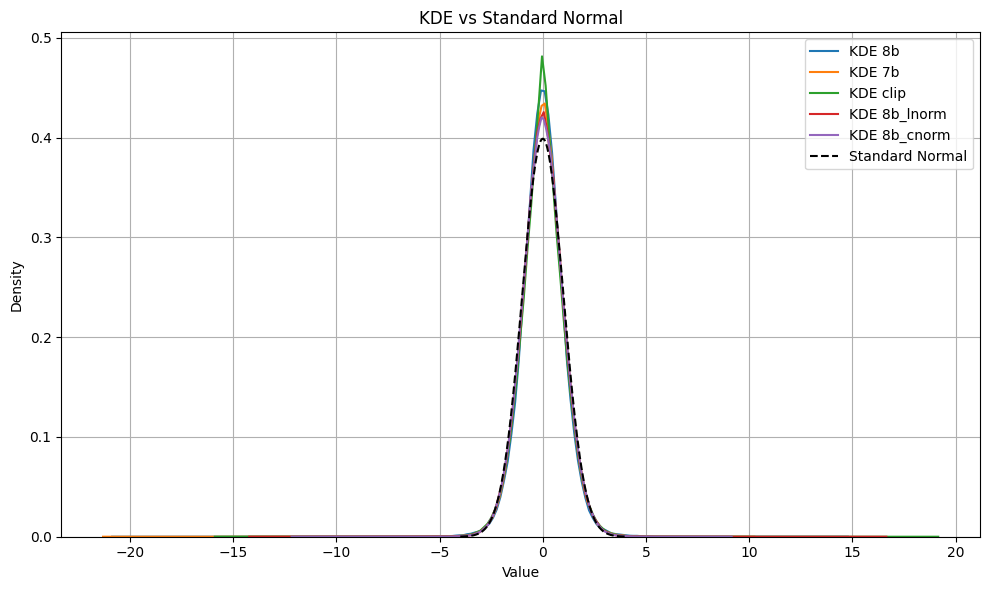

In [18]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 가정: a, b는 1D 또는 다차원 텐서
# data = [a, b, c, d, e]
data = [a, b, c,]
labels = ['8b', '7b', 'clip']
num_samples = 1000000
plt.figure(figsize=(10, 6))

for d, label in zip(data, labels):
    d = d.flatten()  # 1D로 펼치기
    # idx = torch.randperm(d.numel())[:num_samples]
    idx = torch.randint(0, d.numel(), (num_samples,))
    d = d[idx]
    d = (d - d.mean()) / d.std()  # z-score 정규화
    
    sns.kdeplot(d.numpy(), label=f'KDE {label}', bw_adjust=0.5)

# 정규분포 그리기
x = np.linspace(-4, 4, 200)
y = norm.pdf(x)  # 평균 0, 표준편차 1
plt.plot(x, y, 'k--', label='Standard Normal')

plt.title('KDE vs Standard Normal')
plt.xlabel('Value')
plt.ylabel('Density')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


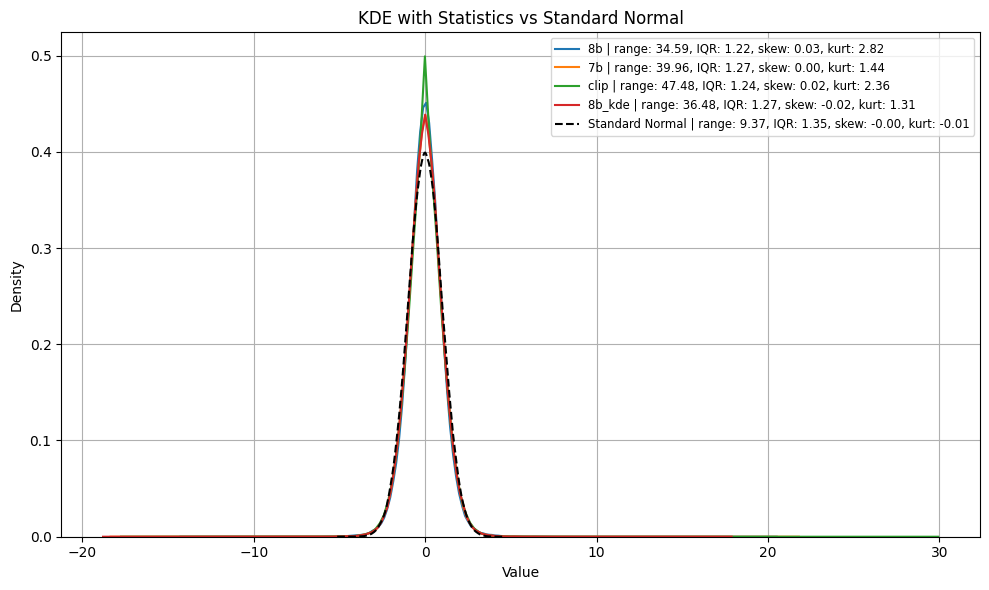

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, iqr, skew, kurtosis

# 가정: a, b, c, d는 torch.Tensor
data = [a, b, c, d]
labels = ['8b', '7b', 'clip', '8b_kde']
num_samples = 1000000
plt.figure(figsize=(10, 6))

# 실제 데이터
for d, label in zip(data, labels):
    d = d.flatten()
    idx = torch.randint(0, d.numel(), (num_samples,))
    d = d[idx]
    d = (d - d.mean()) / d.std()  # z-score 정규화

    d_np = d.cpu().numpy()

    # 통계값 계산
    value_range = d_np.max() - d_np.min()
    iqr_val = iqr(d_np)
    skewness = skew(d_np)
    kurt = kurtosis(d_np)  # Fisher 기준 (정규분포면 0)

    legend_label = (
        f'{label} | '
        f'range: {value_range:.2f}, '
        f'IQR: {iqr_val:.2f}, '
        f'skew: {skewness:.2f}, '
        f'kurt: {kurt:.2f}'
    )

    sns.kdeplot(d_np, label=legend_label, bw_adjust=0.5)

# 정규분포 샘플 생성 및 통계 계산
normal_samples = np.random.normal(loc=0, scale=1, size=num_samples)
value_range = normal_samples.max() - normal_samples.min()
iqr_val = iqr(normal_samples)
skewness = skew(normal_samples)
kurt = kurtosis(normal_samples)

legend_label = (
    f'Standard Normal | '
    f'range: {value_range:.2f}, '
    f'IQR: {iqr_val:.2f}, '
    f'skew: {skewness:.2f}, '
    f'kurt: {kurt:.2f}'
)

sns.kdeplot(normal_samples, label=legend_label, linestyle='--', color='black')

plt.title('KDE with Statistics vs Standard Normal')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


추정한 kde로 random dataset 만들기

6978297856 torch.Size([6814744, 1024])
torch.Size([1000000])
fit done


100%|██████████| 6979/6979 [10:26<00:00, 11.14it/s]


sample done


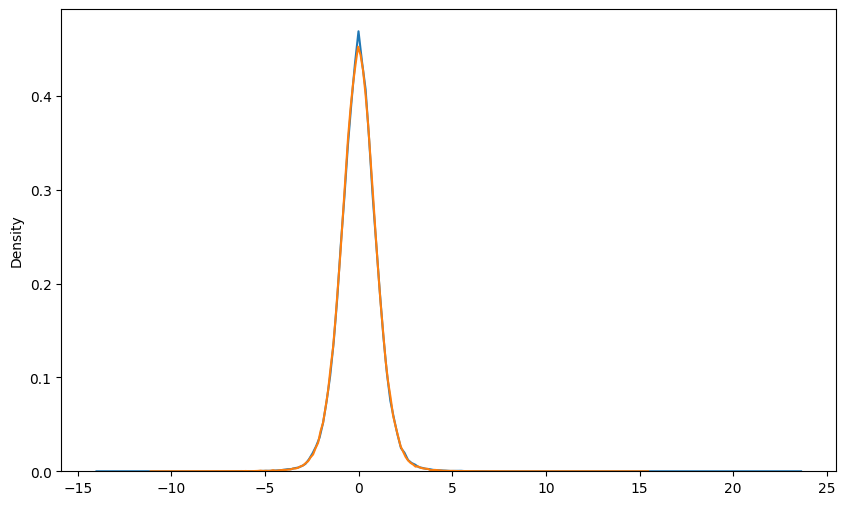

In [7]:
from sklearn.neighbors import KernelDensity
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
# data = [a, b, c, d, e]
# labels = ['8b', '7b', 'clip', '8b_lnorm', '8b_cnorm']

data = [a]
labels = ['8b']

num_samples = 1000000
plt.figure(figsize=(10, 6))

for d, label in zip(data, labels):
    
    original_shape = d.shape
    total_samples = np.prod(original_shape)
    samples_list = []
    print(total_samples, original_shape)
    
    # 데이터 준비 (서브샘플링 및 정규화)
    idx = torch.randint(0, d.numel(), (1000000,))
    normalized_data = (d.flatten()[idx] - d.mean()) / d.std()
    print(normalized_data.shape)
    
    # KDE 피팅
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(normalized_data.reshape(-1, 1))
    print('fit done')
    # 배치 처리로 샘플링
    batch_size=1000000
    for i in tqdm(range(0, total_samples, batch_size)):
        current_batch_size = min(batch_size, total_samples - i)
        batch_samples = kde.sample(n_samples=current_batch_size)
        samples_list.append(torch.tensor(batch_samples))
    print('sample done')
    # 결과 합치기
    s = torch.cat(samples_list, dim=0).view(original_shape)
    
    
    # plot
    d = d.flatten()  # 1D로 펼치기
    # idx = torch.randperm(d.numel())[:num_samples]
    idx = torch.randint(0, original_shape[0], (num_samples,))
    d_sub = d[idx]
    d_sub = (d_sub - d_sub.mean()) / d_sub.std()  # z-score 정규화
    sns.kdeplot(d_sub.numpy(), label=f'KDE {label}', bw_adjust=0.2)
    
    d = s.flatten()  # 1D로 펼치기
    # idx = torch.randperm(d.numel())[:num_samples]
    idx = torch.randint(0, original_shape[0], (num_samples,))
    d_sub = d[idx]
    d_sub = (d_sub - d_sub.mean()) / d_sub.std()  # z-score 정규화
    sns.kdeplot(d_sub.numpy(), label=f'KDE {label}', bw_adjust=0.2)


In [14]:
print(s.shape)
# torch.save(s, '/workspace/Weight_compression/Wparam_dataset/block_pt/synthetic/8b_kde.pt')
datas = s
# indices = torch.randperm(len(datas))
indices = torch.arange(len(datas))
split_index = int(len(datas) - 1000)
train_indices = indices[:split_index]
val_indices = indices[split_index:]

dataset = {}
dataset['train'] = datas[train_indices].float()
dataset['val'] = datas[val_indices].float()
print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

dataset_stats = {}
for split in ['train', 'val']:
    data = dataset[split]
    
    dataset_stats[split] = {
        'mean': data.mean().item(),
        'std': data.std().item(),
        # 'mean_channel': data.mean(dim=0).tolist(),
        # 'std_channel': data.std(dim=0).tolist(),
    }
    
import os
import json
model_name = 'synthetic'
os.makedirs(f'../Wparam_dataset/block_pt/{model_name}', exist_ok = True)
torch.save(dataset, f'../Wparam_dataset/block_pt/{model_name}/8b_kde.pt')
json_path = f'../Wparam_dataset/block_pt/{model_name}/8b_kde_dataset_stats.json'
with open(json_path, 'w') as f:
    json.dump(dataset_stats, f)


torch.Size([6814744, 1024])
train:  torch.Size([6813744, 1024]) val:  torch.Size([1000, 1024])


In [15]:
dataset['train'].dtype

torch.float32

/tmp/ipykernel_2573064/93478451.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


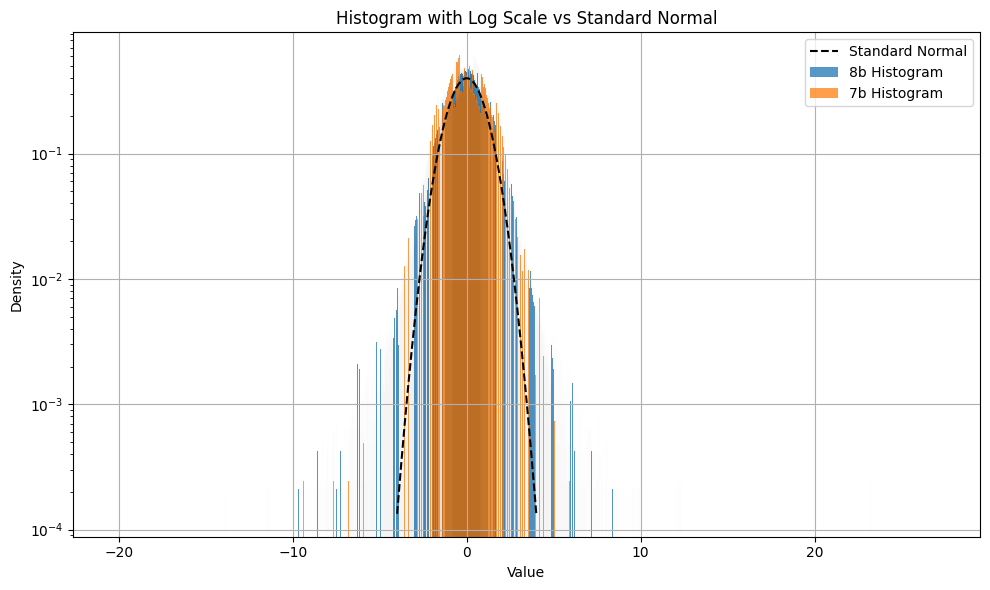

In [15]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 가정: a, b는 1D 또는 다차원 텐서
data = [a, b]
labels = ['8b', '7b']
num_samples = 1000000
plt.figure(figsize=(10, 6))

for d, label in zip(data, labels):
    d = d.flatten()  # 1D로 펼치기
    # idx = torch.randperm(d.numel())[:num_samples]
    idx = torch.randint(0, d.numel(), (num_samples,))
    d = d[idx]
    d = (d - d.mean()) / d.std()  # z-score 정규화
    
    # 히스토그램 그리기 (로그 스케일 적용)
    sns.histplot(d.numpy(), bins=10000, label=f'{label} Histogram', stat='density')
    
# 정규분포 그리기
x = np.linspace(-4, 4, 200)
y = norm.pdf(x)  # 평균 0, 표준편차 1
plt.plot(x, y, 'k--', label='Standard Normal')

# 로그 스케일 설정
plt.yscale('log')

plt.title('Histogram with Log Scale vs Standard Normal')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
